# Agenda

### A- Variational Quantum Algorithm
#### - Parameterized circuit
#### - Spin Hamiltonian operator
#### - VQA & classical optimizer
#### - Example: Quantum Chemistry (VQE-UCCSD) with active space (CPU vs. GPU)

### B- Multi-QPU & Multi-GPU
#### - Example 1: Quantum machine learning (QML)
#### - Example 2: GHZ

### C- Control and adjoint on Kernel function
#### Example: Hadamard Test

### D- Mid-circuit measurement & conditional sampling

### A- Variational Quantum Algorithm
![img](./VQE.png)

#### Parameterized Circuit

In [7]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def param_circuit(theta: list[float]):
    # Allocate a qubit that is initialized to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
parameters = [0.0, 0.0]

print(cudaq.draw(param_circuit,parameters))

# Compute the expectation value using the initial parameters.
expectation_value = cudaq.observe(param_circuit, hamiltonian,parameters).expectation()

print('Expectation value of the Hamiltonian: ', expectation_value)


     ╭───────╮╭───────╮
q0 : ┤ rx(0) ├┤ ry(0) ├
     ╰───────╯╰───────╯

Expectation value of the Hamiltonian:  1.0


### Spin Hamiltonian operator

CUDA-Q defines convenience functions in `cudaq.spin` namespace that produce the primitive X, Y, and Z Pauli operators on specified qubit indices which can subsequently be used in algebraic expressions to build up more complicated Pauli tensor products and their sums.

$H= 5.907 \, I - 2.1433 \, X_0X_1 -2.1433\, Y_0 Y_1 + 0.21829 \, Z_0 -6.125\, Z_1$

```python
spin_operator = 5.907 - 2.1433 * spin.x(0) * spin.x(1) - 2.1433 * spin.y(
    0) * spin.y(1) + .21829 * spin.z(0) - 6.125 * spin.z(1)
```

In [8]:
from cudaq import spin

hamiltonian = 0.5*spin.z(0) + spin.x(1) + spin.y(0) + spin.y(0) * spin.y(1)+ spin.x(0)*spin.y(1)*spin.z(2)

# add some more terms
for i in range(2):
    hamiltonian += -2.0*spin.z(i)*spin.z(i+1)

print(hamiltonian)

print('Total number of terms in the spin hamiltonian: ',hamiltonian.get_term_count())

[-2+0j] IZZ
[-2+0j] ZZI
[1+0j] XYZ
[0.5+0j] ZII
[1+0j] YII
[1+0j] IXI
[1+0j] YYI

Total number of terms in the spin hamiltonian:  7


####  VQA using ```cudaq.observe()``` & classical optimizer.
- Using cudaq built-in optimizer

In [9]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit(theta: list[float]):
    # Allocate a qubit that is initialized to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_param = [0.0, 0.0]

cost_values = []

def cost(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(vqe_circuit, hamiltonian, parameters).expectation()
    cost_values.append(expectation_value)
    return expectation_value

initial_cost_value = cost(initial_param)
print('Initial cost value: ', initial_cost_value)
print('Initial parameters: ', initial_param)

# Define a CUDA-Q optimizer.
optimizer = cudaq.optimizers.COBYLA()
optimizer.initial_parameters = initial_param

result = optimizer.optimize(dimensions=2, function=cost)

print('Final cost value: ', result[0])
print('Optimized parameters: ', result[1])

Initial cost value:  1.0
Initial parameters:  [0.0, 0.0]
Final cost value:  -0.9999999999999981
Optimized parameters:  [3.141592653589793, 0.0]


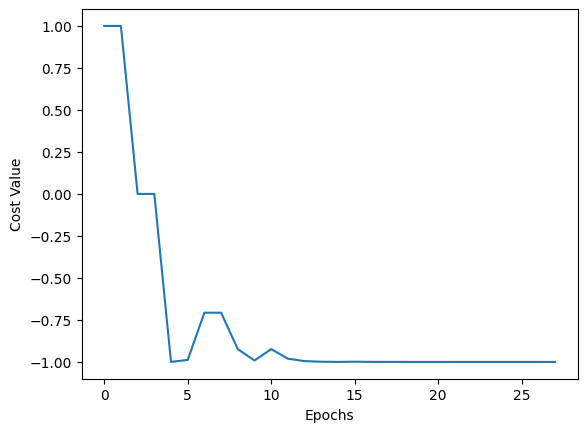

In [10]:
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")
plt.show()

- using third-party optimizer: ex. scipy optimizer

In [11]:
import cudaq
from cudaq import spin
import scipy

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit_scipy(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_parameters = [0.0, 0.0]

def cost_scipy(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(vqe_circuit_scipy, hamiltonian, parameters).expectation()
    return expectation_value

initial_cost_value = cost_scipy(initial_parameters)
print('Initial cost value: ', initial_cost_value)
print('Initial parameters: ', initial_parameters)


result = scipy.optimize.minimize(cost_scipy,initial_parameters,method='COBYLA')
print('Final cost value: ', result.fun)
print('Optimized parameters: ', result.x)

Initial cost value:  1.0
Initial parameters:  [0.0, 0.0]
Final cost value:  -0.9999999970938906
Optimized parameters:  [3.14159466e+00 1.07798234e-04]


### Example:

#### Quantum Chemistry: water molecule with active space (CPU vs. GPU)

### Classical simulation as reference: CCSD

In [2]:
# pip install pyscf
from pyscf import gto, scf, mcscf, cc

geometry='O 0.1173 0.0 0.0; H -0.4691 0.7570 0.0; H -0.4691 -0.7570 0.0'
mol=gto.M(
    atom=geometry,
    spin=0,
    charge=0,
    basis='631g',
)

myhf=scf.RHF(mol)
myhf.max_cycle=100
myhf.kernel()
nelec = mol.nelectron
print('Total number of electrons= ', nelec)
norb = myhf.mo_coeff.shape[1]
print('Total number of orbitals= ', norb)

norb_cas, nele_cas = (4,4)
mycasci = mcscf.CASCI(myhf, norb_cas, nele_cas)
print('ncore occupied orbitals= ', mycasci.ncore)

frozen=[]
frozen+=[y for y in range(0,mycasci.ncore)]
frozen+=[y for y in range(mycasci.ncore+norb_cas, len(mycasci.mo_coeff))]
mycc=cc.CCSD(myhf,frozen=frozen).run()
print('Total CCSD energy for H_act= ', mycc.e_tot, '\n')


converged SCF energy = -75.983975537279


Total number of electrons=  10
Total number of orbitals=  13
ncore occupied orbitals=  3
E(CCSD) = -75.98508980454683  E_corr = -0.001114267267875642
Total CCSD energy for H_act=  -75.98508980454683 



### VQE-UCCSD

/tmp/ipykernel_1032002/3831078893.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham=cudaq.SpinOperator(qubit_hamiltonian)


UCCSD-VQE energy=   -75.98415928173185
Pyscf-CCSD energy=  -75.98508980454683
Total number of qubits:  8
Total number of parameters:  26
Total number of terms in the spin hamiltonian:  105
Total elapsed time (s):  10.89160648197867


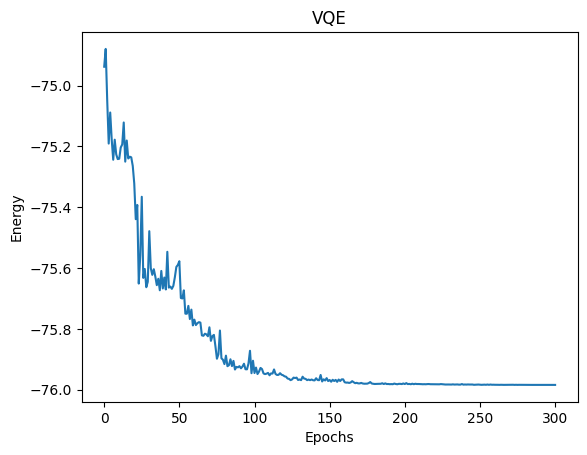

In [13]:
# pip install openfermionpyscf
# pip install openfermion

import openfermion
import openfermionpyscf
from openfermion import generate_hamiltonian
from openfermion.transforms import jordan_wigner, get_fermion_operator
from openfermion.chem import MolecularData

import timeit


import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# GPU
cudaq.set_target("nvidia-fp64")
# CPU
#cudaq.set_target("qpp-cpu")

# 1- Classical pre-processing:

geometry=[('O', (0.1173,0.0,0.0)), ('H', (-0.4691,0.7570,0.0)), ('H', (-0.4691,-0.7570,0.0))]
basis='631g'
multiplicity=1
charge=0
ncore=3
norb_cas, nele_cas = (4,4)

molecule = openfermionpyscf.run_pyscf(openfermion.MolecularData(geometry, basis, multiplicity,charge))

molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(ncore), active_indices=range(ncore,ncore+norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham=cudaq.SpinOperator(qubit_hamiltonian)

# 2- Quantum computing using UCCSD ansatz

electron_count=nele_cas
qubit_count=2*norb_cas

@cudaq.kernel
def kernel(qubit_num:int, electron_num:int, thetas: list[float]):
        qubits = cudaq.qvector(qubit_num)

        for i in range(electron_num):
                x(qubits[i])

        cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,qubit_count)

# Define a function to minimize
def cost(theta):

        exp_val = cudaq.observe(kernel, spin_ham, qubit_count, electron_count, theta).expectation()

        return exp_val


exp_vals = []

def callback(xk):
        exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

# Use the scipy optimizer to minimize the function of interest
start_time = timeit.default_timer()
result = minimize(cost,x0,method='COBYLA',callback=callback, options={'maxiter': 300})
end_time=timeit.default_timer()

print('UCCSD-VQE energy=  ', result.fun)
print('Pyscf-CCSD energy= ', mycc.e_tot)
print('Total number of qubits: ', qubit_count)
print('Total number of parameters: ', parameter_count)
print('Total number of terms in the spin hamiltonian: ',spin_ham.get_term_count())
print('Total elapsed time (s): ', end_time-start_time)

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()


### B- Multi-QPU & Multi-GPU:

#### 1- Multi-QPU (nvidia-mqpu)

The `nvidia-mqpu` target is useful for distributing separate quantum circuits to individual GPUs on a single host machine. 

![img](./circuit-mqpu.png)

#### Example: QML

#### Example with `sample` algorithmic primitives
![img](./RBM.png)

In [59]:
import cudaq

cudaq.set_target("nvidia-mqpu")

target = cudaq.get_target()
qpu_count = target.num_qpus()
print("Number of QPUs:", qpu_count)

@cudaq.kernel
def qrbm(v_nodes:int, h_nodes:int, ancilla:int, theta: list[float], coupling: list[float]):

    qubits_num=v_nodes+h_nodes+ancilla
    qubits=cudaq.qvector(qubits_num)

    for i in range(v_nodes+h_nodes):
        ry(theta[i],qubits[i])

    a_target=v_nodes+h_nodes
    count=0
    for v in range(v_nodes):
        for h in range(v_nodes,v_nodes+h_nodes):
            ry.ctrl(coupling[count],qubits[v],qubits[h],qubits[a_target])
            x(qubits[v])
            ry.ctrl(coupling[count+1],qubits[v],qubits[h],qubits[a_target])
            x(qubits[v])
            x(qubits[h])
            ry.ctrl(coupling[count+1],qubits[v],qubits[h],qubits[a_target])
            x(qubits[v])
            ry.ctrl(coupling[count],qubits[v],qubits[h],qubits[a_target])
            x(qubits[v])
            x(qubits[h])

            count+=2
            a_target+=1

    mz(qubits)    
    
v_nodes=2
h_nodes=2
ancilla=4

# Initialize the parameters for the RBM
theta=[2.0482, 1.4329, 2.1774, 2.7122]
coupling=[1.8256, 3.1415, 1.8257, 3.1415, 3.1415, 0.4152, 3.1415, 0.9654]

count_futures = []

for qpu in range(3):
    count_futures.append(cudaq.sample_async(qrbm,v_nodes, h_nodes, ancilla, theta, coupling, shots_count=10000,qpu_id=qpu))

for counts in count_futures:
    print(counts.get())


Number of QPUs: 5
{ 10110111:10 00010111:17 11100111:9 00000111:6 10011111:98 10111011:4 11011111:18 10011011:75 01011101:142 11110111:581 11011011:6 00010110:84 11100110:28 01111111:894 10110011:3 00111110:30 10110110:13 11111111:920 01101110:18 00111111:14 00011110:160 01000000:1 11001111:1 01001000:2 10110000:343 01001101:1 10011010:261 01101011:2 10111111:14 01011111:9 11111011:532 01010101:78 10100111:2 10100101:47 00001111:4 01101111:6 00001011:2 11110011:310 11011001:243 01101010:12 10111000:532 10001111:48 01000101:1 10111101:236 01000001:1 10111001:172 10101111:3 10110100:531 01001100:6 10110001:88 11101110:43 11101111:16 10111100:914 10111010:23 10111110:34 11001100:22 11001101:3 00101011:1 00111100:902 00111101:243 10011110:397 00011111:43 10110010:10 10110101:169 00101101:43 01010111:1 10101101:87 00101001:16 11011101:415 }

{ 10110111:4 00010111:27 11100111:9 00000111:3 10011111:122 10111011:7 11011111:18 10011011:75 01011101:141 11110111:552 11011011:13 00010110:90 101111

#### Example with `observe` algorithmic primitives

In [14]:
import cudaq
from cudaq import spin
import numpy as np
import timeit

np.random.seed(1)

cudaq.set_target("nvidia-mqpu")
target = cudaq.get_target()
qpu_count = target.num_qpus()
print("Number of QPUs:", qpu_count)

qubit_count = 10
sample_count = 500

ham = spin.z(0)

parameter_count = qubit_count

# Below we run a circuit for 500 different input parameters.
parameters = np.random.default_rng(13).uniform(low=0,high=1,size=(sample_count,parameter_count))

print('Parameter shape: ', parameters.shape)

@cudaq.kernel
def kernel_rx(theta:list[float]):
    qubits = cudaq.qvector(qubit_count)

    for i in range(qubit_count):
        rx(theta[i], qubits[i])

#single GPU
start_time = timeit.default_timer()

result = cudaq.observe(kernel_rx, ham, parameters)
energies = np.array([r.expectation() for r in result])

end_time = timeit.default_timer()
print('Elapsed time (s) for single GPU: ', end_time-start_time)

#print('Energies from single GPU')
#print(energies)


# Multi-GPU

# We split our parameters into 4 arrays since we have 4 GPUs available.
xi = np.split(parameters,4)

print('We have', parameters.shape[0],
      'parameters which we would like to execute')

print('We split this into', len(xi), 'batches of', xi[0].shape[0], ',',
      xi[1].shape[0], ',', xi[2].shape[0], ',', xi[3].shape[0])

print('Shape after splitting', xi[0].shape)
asyncresults = []

start_time = timeit.default_timer()

for i in range(len(xi)):
    for j in range(xi[i].shape[0]):
        asyncresults.append(
            cudaq.observe_async(kernel_rx, ham, xi[i][j, :], qpu_id=i))
        
end_time = timeit.default_timer()
print('Elapsed time (s) for multi-GPU: ', end_time-start_time)

#print('Energies from multi-GPUs')
for result in asyncresults:
    observe_result = result.get()
    got_expectation = observe_result.expectation()
    #print(got_expectation)


Number of QPUs: 5
Parameter shape:  (500, 10)
Elapsed time (s) for single GPU:  1.8108953519258648
We have 500 parameters which we would like to execute
We split this into 4 batches of 125 , 125 , 125 , 125
Shape after splitting (125, 10)
Elapsed time (s) for multi-GPU:  0.005586856976151466


#### 2. Multi-GPU (nvidia-mgpu)

The `nvidia-mgpu` backend is useful for running a large single quantum circuit spread across multiple GPUs.
- A $n$ qubit quantum state has $2^n$ complex amplitudes, each of which require 8 bytes of memory to store. Hence the total memory required to store a n qubit quantum state is $8$ bytes $\times 2^n$. For $n=30$ qubits, this is roughly $8$ GB but for $n=40$, this exponentially increases to $8700$ GB.

#### Example: GHZ

```python
# mpirun -np 4 python <fname> --target nvidia-mgpu

import cudaq

cudaq.mpi.initialize()

qubit_count = 33

@cudaq.kernel
def kernel(qubit_num: int):
    # Allocate our qubits.
    qvector = cudaq.qvector(qubit_num)
    # Place the first qubit in the superposition state.
    h(qvector[0])
    # Loop through the allocated qubits and apply controlled-X,
    # or CNOT, operations between them.
    for qubit in range(qubit_num - 1):
        x.ctrl(qvector[qubit], qvector[qubit + 1])
    # Measure the qubits.
    mz(qvector)

#print("Preparing GHZ state for", qubit_count, "qubits.")
counts = cudaq.sample(kernel, qubit_count)

if cudaq.mpi.rank() == 0:
    print(counts)

cudaq.mpi.finalize()
```

In [15]:
!mpirun -np 4 python ghz.py --target nvidia-mgpu

Preparing GHZ state for 30 qubits.
{ 111111111111111111111111111111:513 000000000000000000000000000000:487 }



### C- Control and adjoint on kernel function

#### Control on kernel function:

In [61]:
import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel
def fancyCnot(a: cudaq.qubit, b: cudaq.qubit):
    x.ctrl(a, b)

@cudaq.kernel
def toffoli():
    q = cudaq.qvector(3)
    ctrl = q.front()
    # without a control, apply x to all
    x(ctrl, q[2])
    cudaq.control(fancyCnot, [ctrl], q[1], q[2])

counts = cudaq.sample(toffoli)

print(counts)

{ 101:1000 }



#### Adjoint on kernel function:

In [62]:
import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel()
def rx_and_h_gate(x : float, q : cudaq.qubit):
    rx(x, q)
    h(q)

@cudaq.kernel()
def kernelAdjoint(N : int):
    q = cudaq.qvector(N)
    cudaq.adjoint(rx_and_h_gate, np.pi, q[2])


counts = cudaq.sample(kernelAdjoint, 4)
print(counts)

{ 0010:503 0000:497 }



#### - Hadamard test: matrix element

Consider the observable $O$ and two generic quantum states $\ket{\psi}$ and $\ket{\phi}$. We want to calculate the quantity
$$
\bra{\psi} O \ket{\phi}.
$$
where $O$ is a Pauli operator.

First of all we shall prepare the states $\ket{\psi}$ and $\ket{\phi}$ using a quantum circuit for each of them. So we  have
$$
\ket{\psi} = U_{\psi}\ket{0} \qquad \ket{\phi} = U_{\phi}\ket{0}
$$

Let's define an observable we want to use:
$$
O = X_1X_2
$$

Now we can evaluate the matrix element using the following fact:
$$
\bra{\psi}O\ket{\phi} = \bra{0}U_\psi^\dagger O U_\phi\ket{0}
$$
This is just an expectation value which can be solved with a simple Hadamard test. The probability to measure $0$ or $1$ in the ancilla qubit is

$$
P(0) = \frac{1}{2} \left[ I + Re \bra{\psi} O \ket{\phi} \right]
$$

$$
P(1) = \frac{1}{2} \left[ I - Re \bra{\psi} O \ket{\phi} \right]
$$

The difference between the probability of $0$ and $1$ gives 

$$
P(0)-P(1) = Re \bra{\psi} O \ket{\phi}
$$

### A- Numerical result as reference:

In [63]:
import cudaq
import numpy as np
from functools import reduce

cudaq.set_target('nvidia')

qubit_num=2

@cudaq.kernel
def psi(num:int):
    q=cudaq.qvector(num)
    h(q[1])
    
@cudaq.kernel
def phi(n:int):
    q=cudaq.qvector(n)
    x(q[0])

psi_state=cudaq.get_state(psi,qubit_num)
print('Psi state: ', psi_state)

phi_state=cudaq.get_state(phi,qubit_num)
print('Phi state: ', phi_state)

ham=cudaq.spin.x(0)*cudaq.spin.x(1)
ham_matrix=ham.to_matrix()
print('hamiltonian: ', np.array(ham_matrix))

exp_val=reduce(np.dot,(np.array(psi_state).conj().T, ham_matrix, phi_state))

print('Numerical expectation value: ', exp_val) 


Psi state:  0.707107+0j 0+0j 0.707107+0j 0+0j 

Phi state:  0+0j 1+0j 0+0j 0+0j 

hamiltonian:  [[0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]]
Numerical expectation value:  (0.7071067690849304+0j)


### B- QC result:

In [64]:

import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel
def U_psi(q:cudaq.qview):
    h(q[1])

@cudaq.kernel
def U_phi(q:cudaq.qview):
    x(q[0])

@cudaq.kernel  
def ham_cir(q:cudaq.qview):
    x(q[0])
    x(q[1])

@cudaq.kernel
def kernel(n:int):
    ancilla=cudaq.qubit()
    q=cudaq.qvector(n)
    h(ancilla)
    cudaq.control(U_phi,ancilla,q)
    cudaq.control(ham_cir,ancilla,q)
    cudaq.control(U_psi,ancilla,q)
    
    h(ancilla)
    
    mz(ancilla)
    
shots=50000    
count=cudaq.sample(kernel,qubit_num, shots_count=shots)    
print(count)

mean_val=(count['0']-count['1'])/shots
error=np.sqrt(2*count['0']*count['1']/shots)/shots
print('Observable QC: ', mean_val,'+ -', error)
print('Numerical result', np.real(exp_val))

{ 0:42613 1:7387 }

Observable QC:  0.70452 + - 0.002244218281718603
Numerical result 0.7071067690849304


### With multi-QPU

In [65]:
import cudaq

cudaq.set_target("nvidia-mqpu")

target = cudaq.get_target()
qpu_count = target.num_qpus()
print("Number of QPUs:", qpu_count)

@cudaq.kernel
def U_psi(q:cudaq.qview, theta:float):
    ry(theta, q[1])

@cudaq.kernel
def U_phi(q:cudaq.qview, theta: float):
    rx(theta, q[0])

@cudaq.kernel  
def ham_cir(q:cudaq.qview):
    x(q[0])
    x(q[1])

@cudaq.kernel
def kernel(n:int, angle:float, theta:float):
    ancilla=cudaq.qubit()
    q=cudaq.qvector(n)
    h(ancilla)
    cudaq.control(U_phi,ancilla,q,theta)
    cudaq.control(ham_cir,ancilla,q)
    cudaq.control(U_psi,ancilla,q, angle)
    
    h(ancilla)
    
    mz(ancilla)
    
shots=50000  
angle=[0.0, 1.5,3.14,0.7]
theta=[0.6, 1.2 ,2.2 ,3.0]

result=[]
for i in range(4):  
    count=cudaq.sample_async(kernel,qubit_num, angle[i], theta[i], shots_count=shots,qpu_id=i)  
    result.append(count)  

mean_val=np.zeros(len(angle))
i=0
for count in result:
    print(i)
    i_result=count.get()
    print(i_result)
    mean_val[i]=(i_result['0']-i_result['1'])/shots
    error=np.sqrt(2*i_result['0']*i_result['1']/shots)/shots
    print('Observable QC: ',  mean_val[i],'+ -', error)
    i+=1
    


Number of QPUs: 5
0
{ 0:24867 1:25133 }

Observable QC:  -0.00532 + - 0.003162232909828117
1
{ 0:24898 1:25102 }

Observable QC:  -0.00408 + - 0.0031622513397894228
2
{ 0:24906 1:25094 }

Observable QC:  -0.00376 + - 0.0031622553065810484
3
{ 0:24911 1:25089 }

Observable QC:  -0.00356 + - 0.003162257621383811


#### Diagonalize the matrix using for example Numpy or CuPy

In [66]:
import numpy as np

my_mat=np.zeros((2,2),dtype=float)
m=0
for k in range(2):
    for j in range(2):
        my_mat[k,j]=mean_val[m]
        m+=1   

print(my_mat)

E,V=np.linalg.eigh(my_mat)

print('Eigen values: ')
print(E)

print('Eigenvector: ')
print(V)



[[-0.00532 -0.00408]
 [-0.00376 -0.00356]]
Eigen values: 
[-0.00830161 -0.00057839]
Eigenvector: 
[[-0.78354466  0.62133547]
 [-0.62133547 -0.78354466]]


### D- Mid-circuit measurement & conditional sampling

In [8]:
import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel
def mid_circuit_m(theta:float):
    qubit=cudaq.qvector(2)
    ancilla=cudaq.qubit()

    ry(theta,ancilla)

    aux=mz(ancilla)
    if aux:
        x(qubit[0])
        x(ancilla)
    else:
        x(qubit[0])
        x(qubit[1])
    
    #mz(ancilla)
    mz(qubit)

angle=0.5
result=cudaq.sample(mid_circuit_m, angle)
print('All: ')
print(result)

c0=result.get_register_counts('aux')
print('The auxillary register: ')
print(c0)

All: 
{ 
  __global__ : { 11:943 10:57 }
   aux : { 0:943 1:57 }
}

The auxillary register: 
{ 0:943 1:57 }



- Here, we see that we have measured the ancilla qubit to a register named ``aux``

- If any measurements appear in the kernel, then only the measured qubits will appear in the ``__global__`` register, and they will be sorted in qubit allocation order.- 